Tm11p400_E1.0_m3.587_H0.155_Ni0.1_R2.633.dat
Tm11p400_E1.0_m3.587_H0.155_Ni0.1_R2.633magnitudes.dat
[False False False ...  True  True  True]


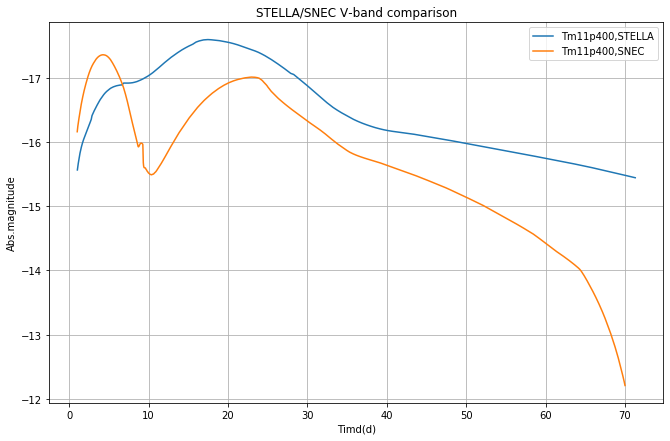

In [3]:
import numpy as np
import scipy
import os.path
from os import rename, listdir
import matplotlib.pyplot as plt


TOPPATH = 'D:/20-intern/simdata/'            # data file storage path
CORRPATH = 'D:/20-intern/BolCorr.dat'        # Corr file path
# TEST.
'''
f = open(TOPPATH+"Tm11p400_E1.0_m3.587_H0.155_Ni0.1_R2.633magnitudes.dat",'r')
print(f.read())
'''
# changing extensions
for file in listdir(TOPPATH):
    print(file)
    if file[-3:]!='dat':
        os.rename(TOPPATH+file, TOPPATH+file+'.dat')
# comparing
plt.rcParams["figure.figsize"] = (11,7)
for file in listdir(TOPPATH):
    if file[-14:-4] == 'magnitudes':
        LC = np.genfromtxt(TOPPATH + file)
        time = LC[:,0] ; V = LC[:,10] ; label = 'SNEC'
        mask = np.zeros(time.shape, bool)                   #masking SNEC file
        mask[time/86400>1] = True
        print(mask)
        plt.plot(time[mask]/86400, V[mask], label = file[:8]+','+label)
    else:
        LC = np.genfromtxt(TOPPATH + file, skip_header=86)
        time = LC[:,0] ; V = LC[:,9] ; label = 'STELLA'
        mask = np.zeros(time.shape, bool)                     #masking STELLA file
        mask[time > 1] = True
        plt.plot(time[mask], V[mask], label = file[:8]+','+label)
plt.gca().invert_yaxis()
plt.title("STELLA/SNEC V-band comparison")
plt.xlabel("Timd(d)");plt.ylabel("Abs.magnitude")
plt.grid()
plt.legend()
plt.show()

# 1. Obtaining the interpolated transformation funtion ($\lambda, T$)

Text(0, 0.5, 'magnitude correction value')

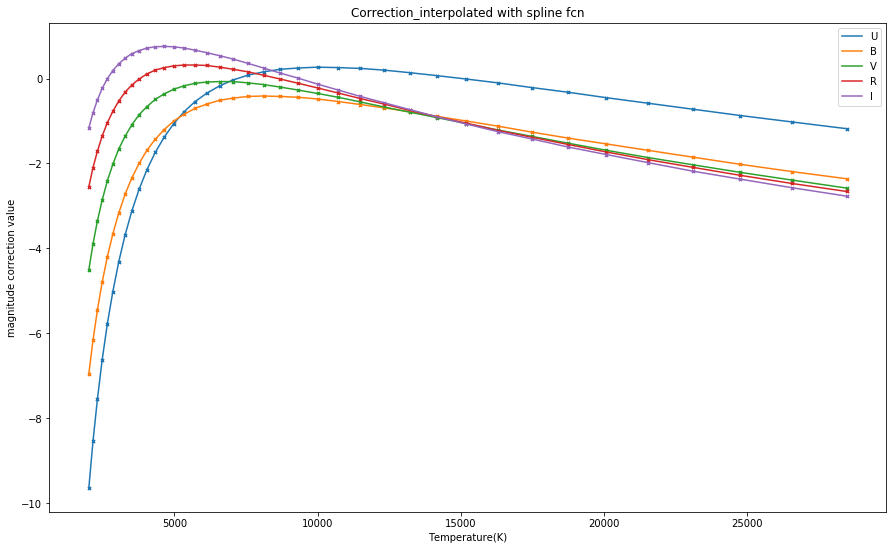

In [4]:
# get a cubic spline-interpolated f(f,T)
from scipy.interpolate import interp1d

BolCorr = np.genfromtxt(CORRPATH)
Type = ['U','B','V','R','I']
T = BolCorr[:,0] ; Value = BolCorr[:,-5:]

Bolintp = interp1d(T,Value, kind = 'cubic', axis = 0)
plt.rcParams["figure.figsize"] = (15,9)

mask = np.zeros(T.shape, bool)                         #masking with Temperature value
mask[(T>2000)&(T<30000)] = True

for i in np.arange(len(Type)):
    plt.plot(T[mask], Bolintp(T)[:,i][mask], label = Type[i])
    plt.scatter(T[mask], Value[:,i][mask], marker = "x", s = 10)
#plt.plot(T,Bolintp(T), label = Type)
plt.legend()
plt.title("Correction_interpolated with spline fcn")
plt.xlabel("Temperature(K)");plt.ylabel("magnitude correction value")

# 2. Stella bolometric magnitude - BolCorr(Tbb)

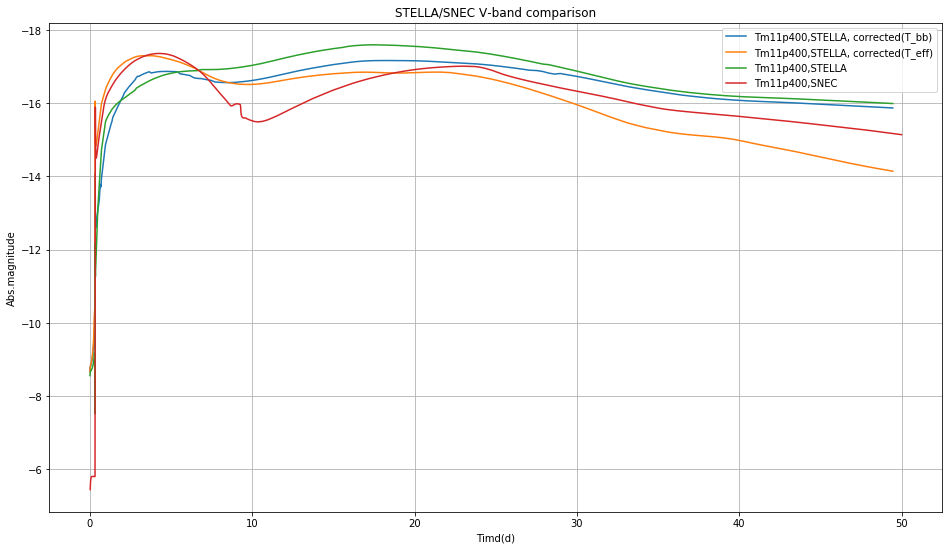

In [6]:
plt.rcParams["figure.figsize"] = (16,9)

for file in listdir(TOPPATH):
    if file[-14:-4] == 'magnitudes':
        LC = np.genfromtxt(TOPPATH + file)
        time = LC[:,0] ; V = LC[:,10] ; label = 'SNEC'
        mask = np.zeros(time.shape, bool)                   #masking SNEC file
        mask[(time/86400>0)&(time/86400<50)] = True
        plt.plot(time[mask]/86400, V[mask], label = file[:8]+','+label)
    else:
        LC = np.genfromtxt(TOPPATH + file, skip_header=86)
        time = LC[:,0] ; V = LC[:,9] ; MBol = LC[:,6] ; label = 'STELLA'
        mask = np.zeros(time.shape, bool)                     #masking STELLA file
        mask[(time > 0)&(time<50)] = True
                
        ###### WARNING ###### in some of the early procedure, T_bb will exceed the interpolated region! 
        T_bb = LC[:,1];T_eff = LC[:,3]
        Tbb_mask = np.ones(time.shape, bool)                 #masking Temperature in the intp.range
        Tbb_mask[(T_bb<1000)|(T_bb>1e6)] = False
        T_bb[~Tbb_mask] = 1e6                                #remporaily set masked values as the maximum value
        BolCorrMat_bb = Bolintp(T_bb)                        #obtaining interpolated MBol correction function (Tbb)
        BolCorrMat_eff = Bolintp(T_eff)
        

        MBol_Corr_bb = MBol - BolCorrMat_bb[:,2]             #Corrected values
        MBol_Corr_eff = MBol-BolCorrMat_eff[:,2]
        Total_mask = Tbb_mask & mask
        plt.plot(time[Total_mask], MBol_Corr_bb[Total_mask], label = file[:8]+','+label+', corrected(T_bb)')
        plt.plot(time[mask], MBol_Corr_eff[mask], label = file[:8]+','+label+', corrected(T_eff)')
        plt.plot(time[mask], V[mask], label = file[:8]+','+label)
        
        
        #print(np.vstack([MBol]*5).T,'\n', BolCorrMat[100:120])
        #print(T_bb[1220:1240])                              # TODO : Label each band automatically
plt.gca().invert_yaxis()
plt.title("STELLA/SNEC V-band comparison")
plt.xlabel("Timd(d)");plt.ylabel("Abs.magnitude")
plt.grid()
plt.legend()